In [1]:
import sys
main_dir = '../'
sys.path.append(main_dir)

from functools import lru_cache

import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import interp1d
import tqdm
import time

import matplotlib.pyplot as plt

import opennu as on
import gammas as ga

plt.style.use(main_dir+'sty.mplstyle')
cols = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

In [18]:
# for tfr in [1, 10,100,1000]:
#     start = time.time()
#     de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
#              tf_ratio=tfr, seed=42, d_init=1e15, d_fin=1e30, ndelta=100, chi2_crit=2.7)
#     check = time.time()-start
#     print(f"tf_ratio: {tfr:d}, de: {de:.2e}, took {check} seconds")

In [22]:
dell = []
dell2 = []
tfl = np.geomspace(0.1, 200, 100)
for tfr in tqdm.tqdm(tfl):
    de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
             tf_ratio=tfr, seed=42, d_init=5e23, d_fin=1e27, ndelta=200, chi2_crit=2.7)
    de2, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
             tf_ratio=tfr, seed=23, d_init=5e23, d_fin=1e27, ndelta=200, chi2_crit=2.7)
    dell.append(de)
    dell2.append(de2)
dell = np.array(dell)
dell2 = np.array(dell2)

 98%|█████████████████████████████████████████████████████████▊ | 98/100 [03:21<00:03,  1.98s/it]

No delta found within scan range


 99%|██████████████████████████████████████████████████████████▍| 99/100 [03:23<00:02,  2.21s/it]

No delta found within scan range


100%|██████████████████████████████████████████████████████████| 100/100 [03:26<00:00,  2.07s/it]

No delta found within scan range


54.22336443514807
58.55044475769315


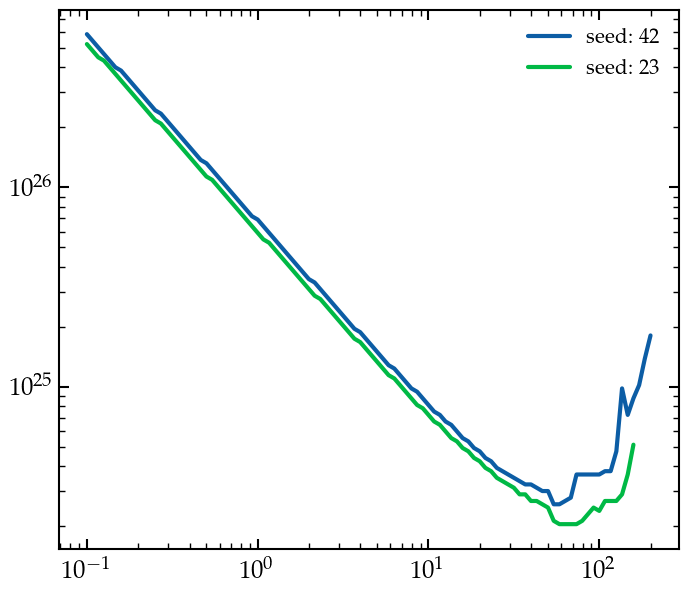

In [35]:
plt.loglog(tfl, dell, label='seed: 42')
plt.loglog(tfl, dell2, label='seed: 23')

print(tfl[np.argmin(dell)])
print(tfl[np.argmin(dell2[:-3])])
plt.legend()
plt.show()

In [46]:
%%time
de, c2 = on.get_delta(10, 0.15, T2=1000, Nshots=10, squid_noise_ratio=0, 
         tf_ratio=55, seed=42, d_init=1e22, d_fin=1e27, ndelta=200, chi2_crit=2.7)
de

CPU times: user 23.3 s, sys: 2.45 s, total: 25.8 s
Wall time: 14 s


np.float64(1.0595601792776148e+22)

In [4]:
%%time
de, c2 = on.get_delta2(10, 0.15, T2=10, Nshots=10, squid_noise_ratio=0, 
         tf_ratio=55, seed=42, d_init=1e22, d_fin=1e27, ndelta=200, chi2_crit=2.7)
de

CPU times: user 2.54 s, sys: 2 ms, total: 2.54 s
Wall time: 2.54 s


np.float64(1.2750512407130181e+23)

In [8]:
%%time
de, c2 = on.get_delta2(10, 0.15, T2=10, Nshots=10, squid_noise_ratio=3, 
         tf_ratio=55, seed=42, d_init=1e22, d_fin=1e32, ndelta=200, chi2_crit=2.7)
de

CPU times: user 3.71 s, sys: 3.01 ms, total: 3.71 s
Wall time: 3.71 s


np.float64(2.9331662783900363e+25)

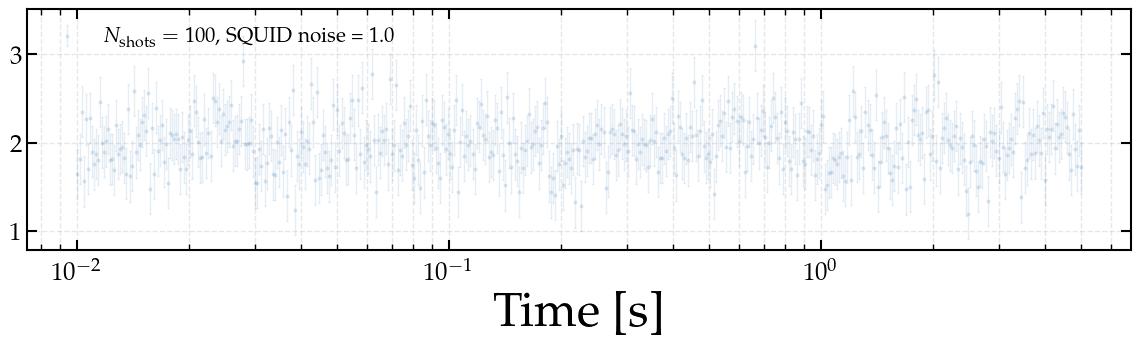

In [8]:
N = int(1e8)
Nshots = 100
sampf = 1e2
tf = 5
ti = 1 / sampf
squid_noise_ratio = 1.0
sk = 1  # skip factor for plotting


# --- Time grid ---
n_times = int((tf - ti) * sampf)
t_exp = np.geomspace(ti, tf, n_times)

# --- Variance (intrinsic + SQUID) ---
intrinsic_var = N / 4
squid_var = squid_noise_ratio * intrinsic_var
true_var = intrinsic_var + squid_var

# --- Simulated noisy data ---
np.random.seed(42)
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp = np.var(Jx_samples, axis=1, ddof=1)

# --- Sample variance error ---
sigma2 = (2 * true_var**2) / (Nshots - 1)
sigma = np.sqrt(sigma2) * np.ones(n_times)

# --- Normalize data and error ---
jx2_exp_norm = Jx2_exp / N * 4
sigma_norm = sigma / N * 4

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.errorbar(t_exp[::sk], jx2_exp_norm[::sk], yerr=sigma_norm[::sk],
             fmt='o', label=fr'$N_{{\rm shots}}={Nshots}$, SQUID noise = {squid_noise_ratio}',
             alpha=0.1, markersize=2, lw=1, capsize=1)

plt.xscale('log')
plt.xlabel("Time [s]")
#plt.ylabel(r"$\langle J_x^2\rangle / (N/4)$")
#plt.title("Simulated noisy $\langle J_x^2\rangle$ measurements")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# %%time
# de, c2 = on.get_delta_jz(10, 0.15, T2=10, Nshots=10, squid_noise_ratio=0, 
#          tf_ratio=55, seed=42, d_init=1e2, d_fin=1e35, ndelta=200, chi2_crit=2.7)
# de

In [7]:
%%time
de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
             tf_ratio=10, seed=42, d_init=1e15, d_fin=1e30, ndelta=100, chi2_crit=2.7)

CPU times: user 3.09 s, sys: 7.82 ms, total: 3.1 s
Wall time: 3.1 s


In [6]:
de

np.float64(6.135907273413188e+23)

In [8]:
%%time
de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
             tf_ratio=100, seed=42, d_init=1e15, d_fin=1e23, ndelta=100, chi2_crit=2.7)

CPU times: user 2min 53s, sys: 6.64 s, total: 3min
Wall time: 42.8 s


In [10]:
de

np.float64(1.6681005372000557e+21)

In [12]:
%%time 
for tf in [0.1, 1, 10]:
    de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
                 tf_ratio=tf, seed=42, d_init=1e15, d_fin=1e30, ndelta=100, chi2_crit=2.7)
    print(de, c2)

2.1544346900318956e+28 2.7419155799523196
8.111308307896889e+25 4.05087650839414
6.135907273413188e+23 4.242213527526474
CPU times: user 11.3 s, sys: 847 ms, total: 12.1 s
Wall time: 12.4 s


In [ ]:
%%time 
for tf in [100, 1000]:
    de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
                 tf_ratio=tf, seed=42, d_init=1e15, d_fin=1e24, ndelta=100, chi2_crit=2.7)
    print(de, c2)

1.519911082952927e+21 3.175583419855684


In [ ]:
%%time 
for tf in [100, 1000]:
    de, c2 = on.get_delta(10, 0.15, T2=1, Nshots=10, squid_noise_ratio=0, 
                 tf_ratio=tf, seed=42, d_init=1e15, d_fin=1e24, ndelta=100, chi2_crit=2.7)
    print(de, c2)

In [2]:
#ratio = 3                # SQUID to SPN ratio from data
#NSQUID = N*ratio**2      # Effective number of spins due to SQUID noise

#### Parameters

In [9]:
R   = 10                 # cm   
mnu = 0.15               # eV
B   = 0.1                # T
ns  = 1.35e22            # cm^-3

gy   = 11.78*1e6          # Hz/T
eVHz = 1/6.58e-16
w0   = 2*np.pi*gy*B/eVHz  # eV
knu  = 2*np.pi/0.21       # cm^-1

N    = ns*4*np.pi/3*R**3  # ~5e22
fsup = 4*(knu*R)**2           

sampf  = 14.3e3           # Hz    (from CASPEr)
T2     = 10                # s
tf     = T2/5             # s
ti     = 1/sampf

n_times = int((tf-ti)*sampf)
t_exp = np.geomspace(ti, tf, n_times)  # s

Nshots  = 100             # Nshots
t_tot   = Nshots*(tf-ti)
gratio, gm = ga.compute_ratio(mnu, w0)

In [19]:
p_init = 0.99
Ncode = 1e8

delta = 1e25

tmin_code = min(t_exp)*N*gm*delta/fsup
tmax_code = max(t_exp)*N*gm*delta/fsup
t1, _, _, j1, _ = on.solve2nd(Ncode, state='G', gp_ratio=gratio, gd_ratio=0, p_init=p_init, ti=tmin_code, tf=tmax_code, ntimes=n_times)

delta = 1e26

tmin_code = min(t_exp)*N*gm*delta/fsup
tmax_code = max(t_exp)*N*gm*delta/fsup
t2, _, _, j2, _ = on.solve2nd(Ncode, state='G', gp_ratio=gratio, gd_ratio=0, p_init=p_init, ti=tmin_code, tf=tmax_code, ntimes=n_times)

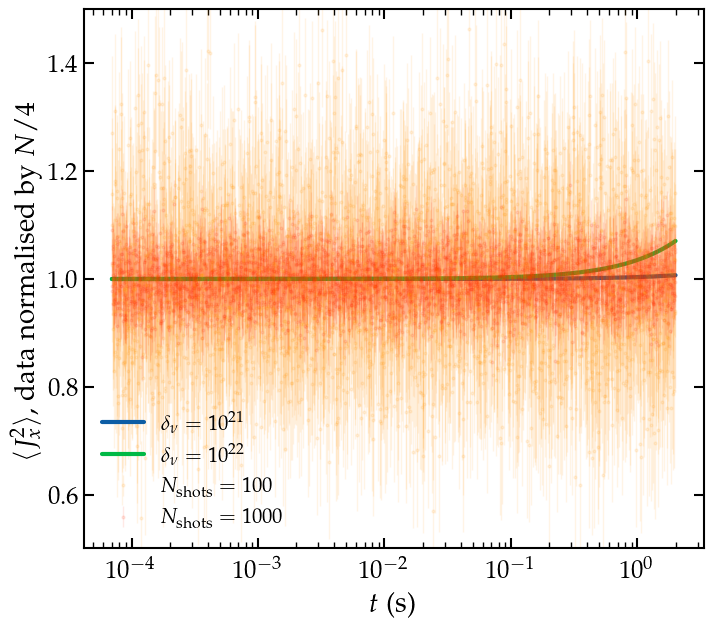

In [22]:
sk = 10

plt.plot(t_exp, j1/Ncode*4, label=r'$\delta_{\nu}=10^{21}$')
plt.plot(t_exp, j2/Ncode*4, label=r'$\delta_{\nu}=10^{22}$')

Nshots = 100
true_var = N/4
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp    = np.var(Jx_samples, axis=1, ddof=1)
sigma2 = (2 * true_var**2) / (Nshots - 1)   
sigma = np.sqrt(sigma2) * np.ones(n_times)
plt.errorbar(t_exp[::sk], Jx2_exp[::sk]/N*4, yerr=sigma[::sk]/N*4, fmt='o', label=r'$N_{\rm shots}=100$', alpha=0.1, markersize=2, lw=1)

Nshots = 1000
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp    = np.var(Jx_samples, axis=1, ddof=1)
sigma2 = (2 * true_var**2) / (Nshots - 1) 
sigma = np.sqrt(sigma2) * np.ones(n_times)
plt.errorbar(t_exp[::sk], Jx2_exp[::sk]/N*4, yerr=sigma[::sk]/N*4, fmt='o', label=r'$N_{\rm shots}=1000$', alpha=0.1, markersize=2, lw=1)

plt.xlabel('$t$ (s)', fontsize=20)
plt.ylabel(r'$\langle J^2_x \rangle$, data normalised by $N/4$', fontsize=20)
plt.xscale('log')
plt.ylim(0.5, 1.5)
plt.legend()
plt.show()

## Pipeline

In [5]:
# To change
R   = 10                 # cm   
mnu = 0.15               # eV
B   = 0.1                # T
sampf  = 14.3e3          # Hz    (from CASPEr)
T2     = 1000            # s
Nshots  = 1000           # Nshots
p_init = 1


ns  = 1.35e22            # cm^-3
gy   = 11.78*1e6          # Hz/T
eVHz = 1/6.58e-16
w0   = 2*np.pi*gy*B/eVHz  # eV
knu  = 1/0.037            # cm^-1 
N    = ns*4*np.pi/3*R**3  # ~5e22
fsup = 4*(knu*R)**2           

tf     = T2/5             # s
ti     = 1/sampf

n_times = int((tf-ti)*sampf)
t_exp = np.geomspace(ti, tf, n_times)  # s
t_tot   = Nshots*(tf-ti)
gratio, gm = ga.compute_ratio(mnu, w0)

# Data
true_var  = N/4
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp    = np.var(Jx_samples, axis=1, ddof=1)
sigma2 = (2 * true_var**2) / (Nshots - 1)   
sigma = np.sqrt(sigma2) * np.ones(n_times)
## Normalised data arrat for jx2
jx2_exp = Jx2_exp/N*4  
sigma   = sigma/N*4

cl = []
delta_crit = 0
chi2_min = 1e100
dl = np.geomspace(1e15,1e29, 100)
for delta in dl:
# delta = 1e22
    Ncode = 1e8
    tmin_code = min(t_exp)*N*gm*delta/fsup
    tmax_code = max(t_exp)*N*gm*delta/fsup
    t, _, _, jx2, _ = on.solve2nd(
        Ncode,
        gp_ratio=gratio,
        gd_ratio=Ncode*0,
        p_init=p_init,
        ti=tmin_code,
        tf=tmax_code,
        ntimes=len(t_exp)
    )
    jx2_pred = jx2/Ncode*4
    chi2 = np.sum(((jx2_exp - jx2_pred)/sigma)**2)
    chi2_min = min(chi2, chi2_min)
    cl.append(chi2)
    if chi2-chi2_min > 2.7:
        delta_crit = delta
        print("Found delta: %.3e"%delta)
        break
    
# dchi = np.array(cl)-np.min(cl)
# print("90p: %.3e"%(dl[np.where(dchi>2.7)[0][0]]))
# print("95p: %.3e"%(dl[np.where(dchi>3.84)[0][0]]))

KeyboardInterrupt: 

90p: 2.848e+26
90p: 3.854e+27
95p: 5.337e+27


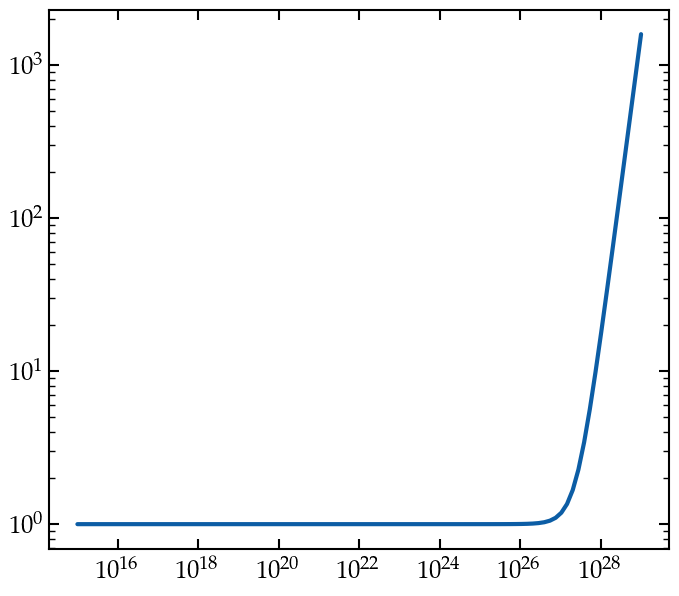

In [255]:
dchi = np.array(cl)/np.min(cl)

plt.loglog(dl, dchi)
print("68p: %.3e"%(dl[np.where(dchi>1.01)[0][0]]))
print("90p: %.3e"%(dl[np.where(dchi>2.7)[0][0]]))
print("95p: %.3e"%(dl[np.where(dchi>3.84)[0][0]]))

plt.show()

In [147]:
Jx2_exp/N*4

array([0.97299894, 0.97961712, 1.00816443, ..., 1.02200488, 0.99687007,
       0.99512761])

In [156]:
jx2_pred = model_Jx2(t_exp, gm, gratio, 0, 1e20, 1)
np.sum(((Jx2_exp/N*4 - jx2_pred) / sigma)**2)

np.float64(9.387049824227888e-46)

In [120]:
# # Step 1: Get best-fit values (global minimum)
# res_global = minimize(
#     chi_squared,
#     x0=[0.1, 1],  # Initial guess: [dep, delta]
#     args=(gm, gratio, p_init, t_exp, Jx2_exp, sigma),
#     bounds=[(1e-3, 1.0), (1, 1e25)]
# )
# dep_best, delta_best = res_global.x
# chi2_min = res_global.fun

In [282]:
# # def model_Jx2(t_eval, de, gp_ratio=0.99, p_init=1):
# #     t_model, _, _, jx2, _ = on.solve2nd(N, state='G',
# #                                         gp_ratio=gp_ratio,
# #                                         gd_ratio=N*de,
# #                                         p_init=p_init,
# #                                         ti=min(t_eval)/1.1,
# #                                         tf=max(t_eval)*1.1)
# #     jx2 = jx2/N*4
# #     #gamma_tot = de / (1 - gp_ratio)  
# #     #t_sec = t_model / (N * gamma_tot)
# #     return interp1d(t_model, jx2, kind='cubic', bounds_error=False, fill_value='extrapolate')(t_eval)

# def chi_squared(params, t_exp, Jx2_exp, sigma):
#     p_init, de = params
#     model_vals = model_Jx2(t_exp, p_init, de)
#     return np.sum(((Jx2_exp - model_vals) / sigma)**2)

# p_init = 0.1
# res = minimize_scalar(chi_squared_p, bounds=(0.001, 10.0), method='Bounded', args=(t_exp, Jx2_exp/N*4, sigma/N*4, p_init))

# # print(f"Best-fit p = {res.x[0]}")
# print(f"Best-fit de = {res.x}")
# print(f"Minimum chi2 = {res.fun}")

## Pipeline example

In [ ]:
# --- Physical Parameters (Set once) ---
R      = 10            # cm
mnu    = 0.15          # eV
B      = 0.1           # T
sampf  = 14.3e3        # Hz (sampling freq)
T2     = 1             # s (coherence)
Nshots = 100
p_init = 1

# --- Constants ---
ns     = 1.35e22        # spin density (cm^-3)
gy     = 11.78e6        # Hz/T
eVHz   = 1 / 6.58e-16
w0     = 2 * np.pi * gy * B / eVHz  # eV
knu    = 1 / 0.037      # cm^-1
N      = ns * 4 * np.pi / 3 * R**3  # Total spins
fsup   = 4 * (knu * R)**2

# --- Time grid ---
tf       = T2 / 5
ti       = 1 / sampf
n_times  = int((tf - ti) * sampf)
t_exp    = np.geomspace(ti, tf, n_times)

# --- Coupling ratios ---
gratio, gm = ga.compute_ratio(mnu, w0)

# --- Generate synthetic J_x data ---
np.random.seed(42)
true_var = N / 4
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp = np.var(Jx_samples, axis=1, ddof=1)

# --- Error on the sample variance ---
sigma2 = (2 * true_var**2) / (Nshots - 1)
sigma = np.sqrt(sigma2) * np.ones(n_times)

# --- Normalize data ---
jx2_exp = Jx2_exp / N * 4
sigma   = sigma / N * 4

# --- Chi-squared scan over delta ---
delta_list = np.geomspace(1e15, 1e29, 100)
chi2_vals = []
chi2_min = np.inf
delta_best = None
delta_crit = None

for delta in delta_list:
    # Solve model
    Ncode = 1e8
    tmin_code = min(t_exp) * N * gm * delta
    tmax_code = max(t_exp) * N * gm * delta
    t_code, _, _, jx2_model, _ = on.solve2nd(
        Ncode,
        gp_ratio=gratio,
        gd_ratio=0,
        p_init=p_init,
        ti=tmin_code,
        tf=tmax_code,
        ntimes=n_times
    )
    jx2_pred = jx2_model / Ncode * 4

    # Chi-squared calculation
    chi2 = np.sum(((jx2_exp - jx2_pred) / sigma) ** 2)
    chi2_vals.append(chi2)

    # Track best
    if chi2 < chi2_min:
        chi2_min = chi2
        delta_best = delta

    # Confidence level threshold (90% CL = 2.7 for 1 parameter)
    if delta_crit is None and chi2 - chi2_min > 2.7:
        delta_crit = delta
        print(f"Found delta_crit = {delta_crit:.3e} at Δχ² = {chi2 - chi2_min:.2f}")

# --- Final Output ---
print(f"Minimum χ²: {chi2_min:.2f}")
print(f"Best-fit delta: {delta_best:.3e}")
if delta_crit:
    print(f"90% CL upper limit on delta: {delta_crit:.3e}")
else:
    print("No delta found within scan range satisfying Δχ² > 2.7.")

# # --- Optional: Plot Δχ² ---
# plt.figure()
# plt.plot(delta_list, np.array(chi2_vals) - chi2_min)
# plt.axhline(2.7, ls='--', color='r', label=r"90% CL")
# plt.axvline(delta_best, color='g', ls=':', label="Best-fit")
# if delta_crit:
    
    jx2_pred = jx2_model / Ncode * 4

    # Chi-squared calculation
    chi2 = np.sum(((jx2_exp - jx2_pred) / sigma) ** 2)
    chi2_vals.append(chi2)

    # Track best
    if chi2 < chi2_min:
        chi2_min = chi2
        delta_best = delta

    # Confidence level threshold (90% CL = 2.7 for 1 parameter)
    if delta_crit is None and chi2 - chi2_min > 2.7:
        delta_crit = delta
        print(f"Found delta_crit = {delta_crit:.3e} at Δχ² = {chi2 - chi2_min:.2f}")

# --- Final Output ---
print(f"Minimum χ²: {chi2_min:.2f}")
print(f"Best-fit delta: {delta_best:.3e}")
if delta_crit:
    print(f"90% CL upper limit on delta: {delta_crit:.3e}")
else:
#     plt.axvline(delta_crit, color='orange', ls='--', label="Upper bound")
# plt.xscale("log")
# plt.xlabel(r"$\delta$")
# plt.ylabel(r"$\Delta \chi^2$")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [6]:
# --- Physical Parameters (Set once) ---
R      = 10            # cm
mnu    = 0.15          # eV
B      = 0.1           # T
sampf  = 14.3e3        # Hz (sampling freq)
T2     = 1             # s (coherence)
Nshots = 100
p_init = 1

# --- Constants ---
ns     = 1.35e22        # spin density (cm^-3)
gy     = 11.78e6        # Hz/T
eVHz   = 1 / 6.58e-16
w0     = 2 * np.pi * gy * B / eVHz  # eV
knu    = 1 / 0.037      # cm^-1
N      = ns * 4 * np.pi / 3 * R**3  # Total spins
fsup   = 4 * (knu * R)**2

# --- Time grid ---
tf       = T2 / 5
ti       = 1 / sampf
n_times  = int((tf - ti) * sampf)
t_exp    = np.geomspace(ti, tf, n_times)

# --- Coupling ratios ---
gratio, gm = ga.compute_ratio(mnu, w0)

# --- Generate synthetic J_x data ---
np.random.seed(42)
true_var = N / 4
Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
Jx2_exp = np.var(Jx_samples, axis=1, ddof=1)

# --- Error on the sample variance ---
sigma2 = (2 * true_var**2) / (Nshots - 1)
sigma = np.sqrt(sigma2) * np.ones(n_times)

# --- Normalize data ---
jx2_exp = Jx2_exp / N * 4
sigma   = sigma / N * 4

# --- Chi-squared scan over delta ---
delta_list = np.geomspace(1e15, 1e29, 100)
chi2_vals = []
chi2_min = np.inf
delta_best = None
delta_crit = None

for delta in delta_list:
    # Solve model
    Ncode = 1e8
    tmin_code = min(t_exp) * N * gm * delta
    tmax_code = max(t_exp) * N * gm * delta
    t_code, _, _, jx2_model, _ = on.solve2nd(
        Ncode,
        gp_ratio=gratio,
        gd_ratio=0,
        p_init=p_init,
        ti=tmin_code,
        tf=tmax_code,
        ntimes=n_times
    )
    jx2_pred = jx2_model / Ncode * 4

    # Chi-squared calculation
    chi2 = np.sum(((jx2_exp - jx2_pred) / sigma) ** 2)
    chi2_vals.append(chi2)

    # Track best
    if chi2 < chi2_min:
        chi2_min = chi2
        delta_best = delta

    # Confidence level threshold (90% CL = 2.7 for 1 parameter)
    if delta_crit is None and chi2 - chi2_min > 2.7:
        delta_crit = delta
        print(f"Found delta_crit = {delta_crit:.3e} at Δχ² = {chi2 - chi2_min:.2f}")

# --- Final Output ---
print(f"Minimum χ²: {chi2_min:.2f}")
print(f"Best-fit delta: {delta_best:.3e}")
if delta_crit:
    print(f"90% CL upper limit on delta: {delta_crit:.3e}")
else:
    print("No delta found within scan range satisfying Δχ² > 2.7.")

# # --- Optional: Plot Δχ² ---
# plt.figure()
# plt.plot(delta_list, np.array(chi2_vals) - chi2_min)
# plt.axhline(2.7, ls='--', color='r', label=r"90% CL")
# plt.axvline(delta_best, color='g', ls=':', label="Best-fit")
# if delta_crit:
    
    jx2_pred = jx2_model / Ncode * 4

    # Chi-squared calculation
    chi2 = np.sum(((jx2_exp - jx2_pred) / sigma) ** 2)
    chi2_vals.append(chi2)

    # Track best
    if chi2 < chi2_min:
        chi2_min = chi2
        delta_best = delta

    # Confidence level threshold (90% CL = 2.7 for 1 parameter)
    if delta_crit is None and chi2 - chi2_min > 2.7:
        delta_crit = delta
        print(f"Found delta_crit = {delta_crit:.3e} at Δχ² = {chi2 - chi2_min:.2f}")

# --- Final Output ---
print(f"Minimum χ²: {chi2_min:.2f}")
print(f"Best-fit delta: {delta_best:.3e}")
if delta_crit:
    print(f"90% CL upper limit on delta: {delta_crit:.3e}")
else:
#     plt.axvline(delta_crit, color='orange', ls='--', label="Upper bound")
# plt.xscale("log")
# plt.xlabel(r"$\delta$")
# plt.ylabel(r"$\Delta \chi^2$")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


SyntaxError: unmatched ')' (2388563545.py, line 93)

In [58]:
R = 10
knu = 1 / 0.037
4*(knu*R)**2

292184.0759678597

In [27]:
def get_delta(R, mnu, p_init):
# --- Physical Parameters ---
    # R      = 10             # cm
    #mnu    = 0.15          # eV
    B      = 0.1           # T
    sampf  = 100e3        # Hz (sampling freq)
    T2     = 100          # s (coherence)
    Nshots = 1000
    # p_init = 1
    
    # --- Constants ---
    ns     = 1.35e22        # spin density (cm^-3)
    gy     = 11.78e6        # Hz/T2
    eVHz   = 1 / 6.58e-16
    w0     = 2 * np.pi * gy * B / eVHz  # eV
    knu    = 1 / 0.037      # cm^-1
    N      = ns * 4 * np.pi / 3 * R**3
    fsup   = 4 * (knu * R)**2
    
    # --- Time grid ---
    # Improvement here?
    tf       = T2 / 5
    ti       = 1 / sampf
    n_times  = int((tf - ti) * sampf)
    t_exp    = np.geomspace(ti, tf, n_times)
    
    # --- gammas ---
    gratio, gm = ga.compute_ratio(mnu, w0)
    
    # --- Generate J_x data ---
    np.random.seed(42)
    true_var = N / 4
    Jx_samples = np.random.normal(0, np.sqrt(true_var), size=(n_times, Nshots))
    Jx2_exp = np.var(Jx_samples, axis=1, ddof=1)
    
    # --- Error on the sample variance ---
    sigma2 = (2 * true_var**2) / (Nshots - 1)
    sigma = np.sqrt(sigma2) * np.ones(n_times)
    
    # --- Normalize data ---
    jx2_exp = Jx2_exp / N * 4
    sigma   = sigma / N * 4
    
    # --- Memoized Solver Wrapper ---
    @lru_cache(maxsize=64)
    def get_model_jx2(delta):
        Ncode = int(1e8)
        tmin_code = min(t_exp) * N * gm * delta / fsup
        tmax_code = max(t_exp) * N * gm * delta / fsup
        t, _, _, jx2, _ = on.solve2nd(
            Ncode,
            gp_ratio=gratio,
            gd_ratio=0,
            p_init=p_init,
            ti=tmin_code,
            tf=tmax_code,
            ntimes=n_times
        )
        return jx2 / Ncode * 4

    # --- Chi-squared scan over delta ---
    delta_list = np.geomspace(1e15, 1e29, 200)
    chi2_vals = []
    chi2_min = np.inf
    delta_best = None
    delta_crit = None
    
    for delta in delta_list:
        jx2_pred = get_model_jx2(delta)
        chi2 = np.sum(((jx2_exp - jx2_pred) / sigma) ** 2)
        chi2_vals.append(chi2)
    
        # Track best
        if chi2 < chi2_min:
            chi2_min = chi2
            delta_best = delta
    
        # Confidence level threshold (90% CL = 2.7 for 1 parameter)
        if delta_crit is None and chi2 - chi2_min > 2.7:
            delta_crit = delta
            break
    return delta_crit, chi2 - chi2_min

In [ ]:
ip = 1 # Initial polarisation
d1 = get_delta(0.1, 0.15, ip)[0]
#d2 = get_delta(0.1,  0.15, ip)[0]

In [ ]:
d1

In [56]:
print(d2/d1)

109.69857978923908


In [57]:
print(get_delta(10, 0.15, 1)[0])
print(get_delta(10,  0.15, 0.5)[0])

1.1097524964120699e+26
4.768611697714455e+26


In [45]:
ip = 1 # Initial polarisation

print(get_delta(0.15, ip)[0])
print(get_delta(0.55, ip)[0])  # 100kHz sampl., T2=10s, 1000 Nshots

2.2739657523579321e+24
6.222570836730231e+23


In [25]:
ip = 0.1 # Initial polarisation

print(get_delta(0.15, ip)[0])
print(get_delta(0.55, ip)[0])

5.6071699382054234e+26
1.5343684089300131e+26


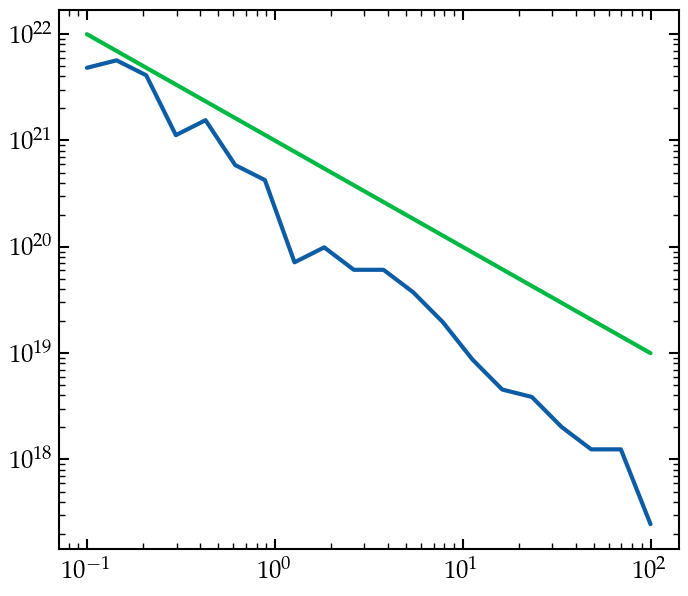

In [351]:
## T2 dep

plt.loglog(T2l, np.array(dell)[:,0])
plt.loglog(T2l,1e21/T2l)

In [355]:
nl = np.geomspace(10,1000, 30)
dell = []
for n in tqdm.tqdm(nl):
    nn = int(n)
    dell.append(get_delta(0.1, nn)[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.09s/it]


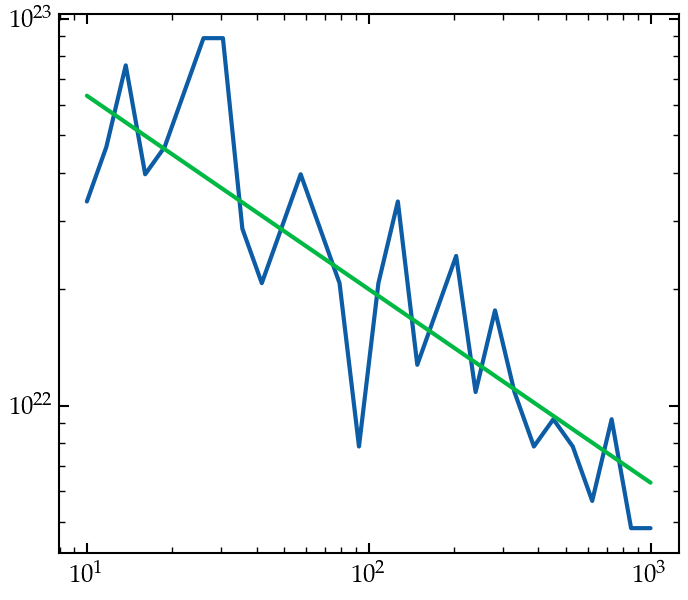

In [358]:
## Nshots dep
plt.loglog(nl, np.array(dell))
plt.loglog(nl,2e23/np.sqrt(nl))